In [1]:
import numpy as np

In [2]:
TOTAL_ACTIONS = 2
TOTAL_DEALER_CARDS = 10
TOTAL_PLAYER_SUM = 10
ACTION_HIT = 0
ACTION_STICK = 1
ACTIONS = np.arange(2)

In [3]:
PI_PLAYER = np.zeros(22)
PI_PLAYER[:20] = ACTION_HIT
PI_PLAYER[20] = ACTION_STICK
PI_PLAYER[21] = ACTION_STICK
PI_PLAYER = PI_PLAYER.astype(int)

PI_DEALER = np.zeros(22)
PI_DEALER[:17] = ACTION_HIT
PI_DEALER[17:] = ACTION_STICK
PI_DEALER = PI_DEALER.astype(int)

In [4]:
print(PI_PLAYER)
print(PI_DEALER)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [5]:
def target_pi(player_cards_sum, var1 = None, var2 = None):
    return PI_PLAYER[player_cards_sum]

def behaviour_pi_1(var1 = None, var2 = None, var3 = None):
    p = np.random.rand()
    if p <= 0.5:
        return ACTION_HIT
    return ACTION_STICK

In [6]:
def draw_random_card():
    return min(np.random.randint(1, 14), 10)

def get_card_value(card):
    if card == 1:
        return 11
    return card

In [7]:
def player_turn(St, At, trajectory, pi_player, verbose = False):
    usable_ace_player, player_cards_sum, dealer_first_card = St
    while True:
        if At is None:
            At = pi_player(player_cards_sum, usable_ace_player, dealer_first_card)
            
        trajectory.append([St, At])
        
        if verbose:
            print("Player at State:", St)
            print("Player chooses Action:", At)
        
        if At == ACTION_STICK:
            if verbose:
                print("Player Sticks")
            return None, player_cards_sum
        
        num_aces = int(usable_ace_player)
        card = draw_random_card()
        
        if verbose:
            print("Card drawn after player decides to HIT:", card)
            
        if card == 1:
            num_aces += 1
        
        player_cards_sum += get_card_value(card, )
        
        while player_cards_sum >= 22 and num_aces > 0:
            player_cards_sum -= 10
            num_aces -= 1
            
        if player_cards_sum >= 22:
            if verbose:
                print("Player card sum becomes greater than 21")
            return [St, -1, trajectory], player_cards_sum
        
        if num_aces == 1:
            usable_ace_player = True
        else:
            usable_ace_player = False
            
        St = [usable_ace_player, player_cards_sum, dealer_first_card]
        At = pi_player(player_cards_sum, usable_ace_player, dealer_first_card)
        if verbose:
            print("Player reaches state:", St)
            


In [8]:
def dealer_turn(dealer_cards_sum, usable_ace_dealer, St, trajectory, verbose = False):
    St_ = [usable_ace_dealer, dealer_cards_sum]
    while True:
        At = PI_DEALER[dealer_cards_sum]
        
        if verbose:
            print("Dealer at State:", St_)
            print("Dealer chooses Action:", At)
        
        if At == ACTION_STICK:
            if verbose:
                print("Dealer Sticks")
            return None, dealer_cards_sum
        
        num_aces = int(usable_ace_dealer)
        card = draw_random_card()
        
        if verbose:
            print("Card drawn after dealer decides to HIT:", card)
        
        if card == 1:
            num_aces += 1
        dealer_cards_sum += get_card_value(card)
        while dealer_cards_sum >= 22 and num_aces > 0:
            dealer_cards_sum -= 10
            num_aces -= 1
        if dealer_cards_sum >= 22:
            if verbose:
                print("Dealer card sum becomes greater than 21")
            return [St, 1, trajectory], dealer_cards_sum
        
        if num_aces == 1:
            usable_ace_dealer = True
        else:
            usable_ace_dealer = False
            
        St_ = [usable_ace_dealer, dealer_cards_sum]
        if verbose:
            print("Dealer reaches state:", St_)

In [9]:
def generate_episode(pi_player, St = None, At = None, verbose = False):
    player_cards_sum = 0
    dealer_cards_sum = 0
    dealer_first_card = None
    dealer_second_card = None
    usable_ace_player = False
    usable_ace_dealer = False
    trajectory = []
    
    if St is not None:
        usable_ace_player = St[0]
        player_cards_sum = St[1]
        dealer_first_card = St[2]
        dealer_second_card = draw_random_card()
    else:
        while True:
            card = draw_random_card()
            player_cards_sum += get_card_value(card)
            
            if player_cards_sum == 22:
                player_cards_sum = 12
                usable_ace_player = usable_ace_player or (card == 1)
            
            if player_cards_sum >= 12:
                break
        dealer_first_card = draw_random_card()
        dealer_second_card = draw_random_card()
        St = [usable_ace_player, player_cards_sum, dealer_first_card]
        
    result_player, player_cards_sum = player_turn(St, At, trajectory, pi_player, verbose=verbose) 
    
    if result_player is not None:
        return result_player
    
    dealer_cards_sum = get_card_value(dealer_first_card) + get_card_value(dealer_second_card)
    if dealer_first_card == 1 or dealer_second_card == 1:
        usable_ace_dealer = True
    else:
        usable_ace_dealer = False
    
    if dealer_cards_sum == 22:
        dealer_cards_sum = 12
        
    result_dealer, dealer_cards_sum = dealer_turn(dealer_cards_sum, usable_ace_dealer, St, trajectory, verbose=verbose)
    
    if result_dealer is not None:
        return result_dealer
    
    if player_cards_sum > dealer_cards_sum:
        return St, 1, trajectory
    elif player_cards_sum == dealer_cards_sum:
        return St, 0, trajectory
    return St, -1, trajectory 
            

In [10]:
generate_episode(target_pi, verbose=True)

Player at State: [False, 12, 7]
Player chooses Action: 0
Card drawn after player decides to HIT: 1
Player reaches state: [False, 13, 7]
Player at State: [False, 13, 7]
Player chooses Action: 0
Card drawn after player decides to HIT: 10
Player card sum becomes greater than 21


[[False, 13, 7], -1, [[[False, 12, 7], 0], [[False, 13, 7], 0]]]

In [11]:
def MC_on_policy(num_episodes):
    usable_ace_state_reward_sum = np.zeros((10, 10), dtype = int)
    usable_ace_state_count = np.ones((10, 10), dtype = int)    
    not_usable_ace_state_reward_sum = np.zeros((10, 10), dtype = int)    
    not_usable_ace_state_count = np.ones((10, 10), dtype = int)   
    
    for i in range(num_episodes):
        _, reward, trajectory = generate_episode(target_pi, verbose=False)
        
        for [usable_ace_player, player_cards_sum, dealer_first_card], _ in trajectory:
            if usable_ace_player:
                usable_ace_state_reward_sum[player_cards_sum-12, dealer_first_card-1] += reward
                usable_ace_state_count[player_cards_sum-12, dealer_first_card-1] += 1
            else:
                not_usable_ace_state_reward_sum[player_cards_sum-12, dealer_first_card-1] += reward
                not_usable_ace_state_count[player_cards_sum-12, dealer_first_card-1] += 1
                
    return usable_ace_state_reward_sum / usable_ace_state_count, not_usable_ace_state_reward_sum / not_usable_ace_state_count

In [12]:
def MC_off_policy(num_episodes):
    St = [True, 13, 2]

    ratios = np.zeros((num_episodes))
    rewards = np.zeros((num_episodes))

    for i in range(num_episodes):
        _, reward, trajectory = generate_episode(behaviour_pi_1, St=St)

        numerator = 1.0
        denominator = 1.0
        for (usable_ace_player, player_cards_sum, _), action in trajectory:
            if action != target_pi(player_cards_sum):
#                 0.0 because target policy is a deterministic policy
                numerator = 0.0
                break
            denominator *= 0.5
        ratios[i] = numerator / denominator
        rewards[i] = reward
    
    weighted_returns = np.cumsum(np.multiply(ratios, rewards))
    ratios = np.cumsum(ratios)

    ordinary_sampling = weighted_returns / (np.arange(num_episodes)+1)

    weighted_sampling = weighted_returns / (ratios + 1e-14)

    return ordinary_sampling, weighted_sampling

In [13]:
def get_behavior_pi_2(state_action_values, state_action_pair_count):
    def behavior_pi_2(player_cards_sum, usable_ace_player, dealer_first_card):
        usable_ace_player = int(usable_ace_player)
        player_cards_sum -= 12
        dealer_first_card -= 1
        values = state_action_values[usable_ace_player, player_cards_sum, dealer_first_card, :] / state_action_pair_count[usable_ace_player, player_cards_sum, dealer_first_card, :]
        max_action_list = []
        max_value = np.max(values)
        for action, value in enumerate(values):
            if value == max_value:
                max_action_list.append(action)
        return np.random.choice(max_action_list)
    return behavior_pi_2

def MC_exploring_starts(num_episodes):
    state_action_values = np.zeros((2, TOTAL_PLAYER_SUM, TOTAL_DEALER_CARDS, TOTAL_ACTIONS))
    state_action_pair_count = np.ones((2, TOTAL_PLAYER_SUM, TOTAL_DEALER_CARDS, TOTAL_ACTIONS))
    
    behaviour_pi = get_behavior_pi_2(state_action_values, state_action_pair_count)
    pi_player = None
    
    for episode in range(num_episodes):
        St = [bool(np.random.randint(2)), np.random.randint(10)+12, np.random.randint(10)+1]
        At = np.random.choice(ACTIONS)
        if episode == 0:
            pi_player = target_pi
        else:
            pi_player = behaviour_pi
            
        _, reward, trajectory = generate_episode(pi_player, St=St, At=At, verbose=False)
        for (usable_ace_player, player_cards_sum, dealer_first_card), action in trajectory:
            state_action_values[int(usable_ace_player), player_cards_sum-12, dealer_first_card-1, action] += reward
            state_action_pair_count[int(usable_ace_player), player_cards_sum-12, dealer_first_card-1, action] += 1

    return state_action_values / state_action_pair_count


In [14]:
def figure_5_1():
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D 
    
    states_usable_ace_1, states_no_usable_ace_1 = MC_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = MC_on_policy(500000)
    
    X = range(1, 11)
    Y = list(reversed(range(12, 22)))
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, np.flipud(states_usable_ace_1), linewidth=0, antialiased=False)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_zlabel('Expected Return')
    ax.set_title('Usable Ace, 10000 Episodes')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, np.flipud(states_usable_ace_2), linewidth=0, antialiased=False)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_zlabel('Expected Return')
    ax.set_title('Usable Ace, 500000 Episodes')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, np.flipud(states_no_usable_ace_1), linewidth=0, antialiased=False)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_zlabel('Expected Return')
    ax.set_title('No Usable Ace, 10000 Episodes')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, np.flipud(states_no_usable_ace_2), linewidth=0, antialiased=False)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_zlabel('Expected Return')
    ax.set_title('No Usable Ace, 500000 Episodes')
    plt.show()
    
        
    plt.close("all")

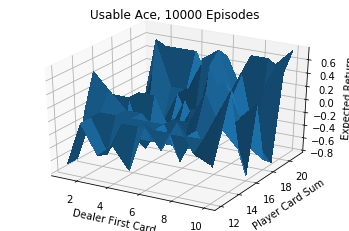

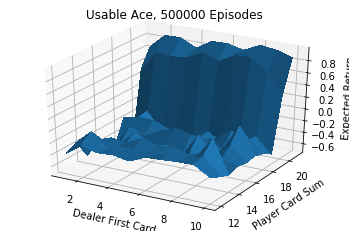

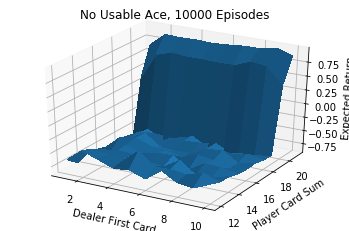

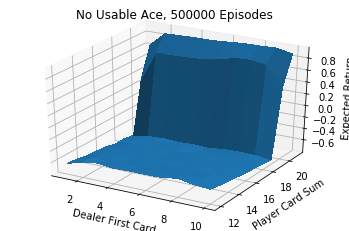

In [20]:
figure_5_1()

In [16]:
def figure_5_2():
    import seaborn as sns
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D 
    
    
    state_action_values = MC_exploring_starts(500000)

    state_value_no_usable_ace = np.max(state_action_values[0, :, :, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[1, :, :, :], axis=-1)

    action_no_usable_ace = np.argmax(state_action_values[0, :, :, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[1, :, :, :], axis=-1)
    
    X = range(1, 11)
    Y = list(reversed(range(12, 22)))
    X_, Y_ = np.meshgrid(X, Y)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(np.flipud(action_usable_ace), cmap="YlGnBu", ax=ax, xticklabels=X, yticklabels=Y)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_title('Optimal policy - Usable Ace')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_, Y_, np.flipud(state_value_usable_ace), linewidth=0, antialiased=False)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_zlabel('expected return')
    ax.set_title('Optimal value - Usable Ace')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(np.flipud(action_no_usable_ace), cmap="YlGnBu", ax=ax, xticklabels=X, yticklabels=Y)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_title('Optimal policy - No usable Ace')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_, Y_, np.flipud(state_value_no_usable_ace), linewidth=0, antialiased=False)
    ax.set_ylabel('Player Card Sum')
    ax.set_xlabel('Dealer First Card')
    ax.set_zlabel('expected return')
    ax.set_title('Optimal value - No usable Ace')
    plt.show()
    
    plt.close("all")

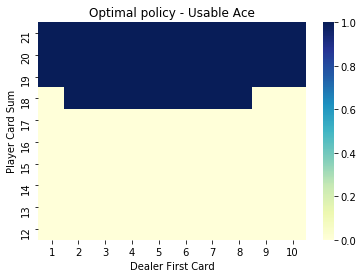

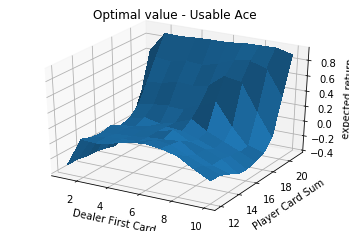

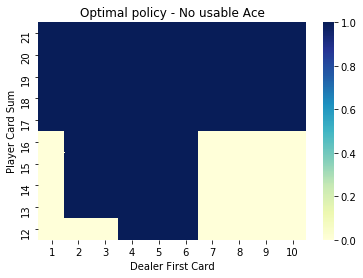

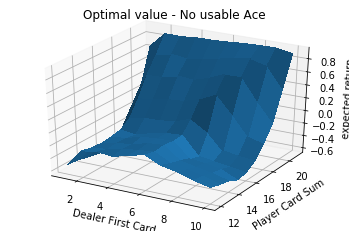

In [17]:
figure_5_2()

In [39]:
def figure_5_3():
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    true_value = -0.27726
    error_ordinary = np.zeros(10000)
    error_weighted = np.zeros(10000)
    for i in range(100):
        ordinary_sampling, weighted_sampling = MC_off_policy(10000)
        error_ordinary += (ordinary_sampling - true_value)**2
        error_weighted += (weighted_sampling - true_value)**2
    error_ordinary /= 100
    error_weighted /= 100

    fig = plt.figure()
    plt.plot(error_ordinary, label='Ordinary Sampling')
    plt.plot(error_weighted, label='Weighted Sampling')
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('Mean square error (Averaged Over 100 runs)')
    plt.xscale('log')
    plt.ylim(0, 4)
    plt.legend()

    plt.show()
    plt.close("all")

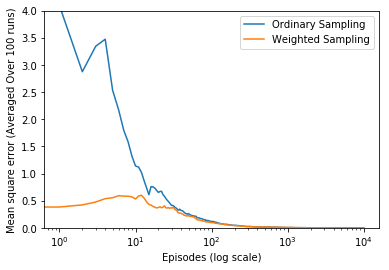

In [40]:
figure_5_3()